**Objective**

1. Task at hand is creating an Encoder Decoder based Deep Neural Network for transliteration (or loosely translation) from Hindi to English.
2. We will train a Seq2Seq Transliteration model with attention for SignBoard Tranliteration Project. 
3. Dataset used is NEWS2018


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt;plt.style.use('ggplot')
import seaborn as sns
from IPython.display import clear_output
import random
# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!pip install pytorch-nlp
from torchnlp.metrics import get_moses_multi_bleu as bleu
!rm -rf 'sample_data'

     |████████████████████████████████| 92kB 6.1MB/s 


## Data Management

### Alphabets Setup

In [3]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)

# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)
hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}
{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔

### Helper functions for data pre-processing

In [4]:
#re - Regular Expressions (RegEx) rejects Python library for string processing
import re
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# Remove all English non-letters
def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()
    line = non_eng_letters_regex.sub('', line)
    return line.split()

# Remove all Hindi non-letters
def cleanHindiVocab(line):
    line = line.replace('-', ' ').replace(',', ' ')
    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
    return cleaned_line.split()

## Dataset Loading

In [5]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET

class TransliterationDataLoader(Dataset):
    def __init__(self, filename):
        self.eng_words, self.hindi_words = self.readXmlDataset(filename, cleanHindiVocab)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
        
    def __len__(self):
        return len(self.eng_words)
    
    def __getitem__(self, idx):
        return self.eng_words[idx], self.hindi_words[idx]
    
    def readXmlDataset(self, filename, lang_vocab_cleaner):
        transliterationCorpus = ET.parse(filename).getroot()
        lang1_words = []
        lang2_words = []

        for line in transliterationCorpus:
            wordlist1 = cleanEnglishVocab(line[0].text)
            wordlist2 = lang_vocab_cleaner(line[1].text)

            # Skip noisy data
            if len(wordlist1) != len(wordlist2):
                print('Skipping: ', line[0].text, ' - ', line[1].text)
                continue

            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)

        # return lang1_words, lang2_words
        return lang2_words, lang1_words

    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))
    
    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
    
    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1
        
        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
            
        return eng_batch, hindi_batch

In [6]:
train_data = TransliterationDataLoader('/content/drive/My Drive/Colab Notebooks/CapstoneProject/NEWS2012-Training-EnHi-13937.xml')
test_data = TransliterationDataLoader('/content/drive/My Drive/Colab Notebooks/CapstoneProject/NEWS2012-Ref-EnHi-1000.xml')

Skipping:  BARHARWA JUNCTION  -  बरहरवा
Skipping:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping:  KING EDWARD VII  -  किंग एडवर्ड
Skipping:  DIBANG VALLEY  -  दिबंगवैली
Skipping:  ORDER OF VASA  -  ऑडर ऑफ़ द वासा
Skipping:  AZAMNAGAR ROAD  -  आज़मनगर
Skipping:  CAPE TOWN  -  केपटाउन
Skipping:  NEW ZEALAND  -  न्यूज़ीलैंड
Skipping:  SEA OF THE HEBRIDES  -  सी ऑफ हरब्रिड्‍स
Skipping:  RAMCOIND  -  राम्को इंड
Skipping:  KELVINGROVE ART GALLERY AND MUSEUM  -  केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
Skipping:  AUSTRALIAN NATIONAL UNIVERSITY  -  ऑस्ट्रेलियननेशनल यूनिवर्सिटी
Skipping:  JAHAN AARA  -  जहाँआरा
Skipping:  NAVABHARAT FERRO ALLOYS  -  नव भारत फ़ैरो अलॉय
Skipping:  RAMA LINGESHWARA  -  रामालिंगेश्वर
Skipping:  FAKHRUN NISA  -  फखरुन्निसा
Skipping:  REDIFF.COM INDIA LIMITED  -  रेडिफ़ डॉट कॉम इंडिया लिमिटेड
Skipping:  OMKARNATH THAKUR  -  ओंकार नाथ ठाकुर
Skipping:  OPENTV  -  ओपन टीवी
Skipping:  ENVOY COMMUNICATIONS GROUP  

### Basic Data Visualization

In [7]:
print("Train Set Size:\t", len(train_data))
print("Test Set Size:\t", len(test_data))

print('\nSample data from train-set:')
for i in range(100):
    eng, hindi = train_data.get_random_sample()
    print(eng + ' - ' + hindi)

Train Set Size:	 20543
Test Set Size:	 1000

Sample data from train-set:
भाई - BHAI
धरम - DHARAM
हिल - HILL
सुखदेव - SUKHDEV
डी - D
दोनों - DONO
इआन - IAN
विल्फ - WILF
बादल - BADAL
मॉम - MOM
सैफुल - SAFUL
भाई - BHAI
वर्जीनिया - VIRGINIA
टेलीफ़ोनिका - TELEFONICA
हँसते - HANSTE
इंदिरापुरम - INDIRAPURAM
श्चेल्फी - SHELF
एर्ने - ARNE
ब्रूस - BRUCE
ग्रेफ - GRAF
स्मिता - SMITAA
स्लोन - SLONE
लक्ष्मीनारायण - LAXMINARAYAN
सेंटेक्स - CENTEX
एल्विन - ALVIN
डैम - DAM
गरीबी - GARIBI
कसम - KASAM
कुलोन - KULON
हर - HAR
देखो - DEKHO
स्कूल - SCHOOL
नेशनल - NATIONAL
सिडोनी - SIDONIE
मुस्तफीद - MUSTAFEED
बॉसमन - BOSMAN
दौलत - DAULAT
टिम - TIM
महल - MAHAL
सुदीप्ता - SUDIPTA
क़बील - QABEEL
व्हिटब्रेड - WHITBREAD
गोल्ड - GOLD
बांकेबिहारी - BANKEBIHARI
कैटिच - KATICH
सुबर्ना - SUBARNA
सहारा - SAHARA
सीमा - SEEMA
इंटरनेशनल - INTERNATIONAL
लेक - LAKE
सपेरा - SAPERA
आनंदपुर - ANANDPUR
सीवान - SIWAN
जाम - JAM
निरूपमा - NIRUPAMA
मैरिस्का - MARISKA
इंटर - INTER
वेलाडेरो - VELADERO
क्लिंटन - CLINTON
गैज़ेली - GAZEL

### Encoding the words

In [8]:
def hindi_rep(word, letter2index, device = 'cpu'):
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][0][pad_pos] = 1
    return rep

def eng_rep(word, letter2index, device = 'cpu'):
    rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0] = pos
    rep[letter_index+1][0] = letter2index[pad_char]
    return rep

## Network Architecture

In [9]:
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder_Attention(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super(Transliteration_EncoderDecoder_Attention, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.U = nn.Linear(self.hidden_size, self.hidden_size) #U_attn
        self.W = nn.Linear(self.hidden_size, self.hidden_size) #W_attn
        self.attn = nn.Linear(self.hidden_size, 1) #V_attn
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)   
        
        self.verbose = verbose
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        
        # encoder
        encoder_outputs, hidden = self.encoder_rnn_cell(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        
        if self.verbose:
            print('Encoder output', encoder_outputs.shape)
        
        # decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        
        outputs = []
        U = self.U(encoder_outputs)
        
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)
        
        for i in range(max_output_chars):
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attn(torch.tanh(U + W))
            attn_weights = F.softmax(V.view(1, -1), dim = 1) 
            
            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attn', attn_weights.shape)
            
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            
            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)
            
            if self.verbose:
                print('Attn LC', attn_applied.shape)
                print('Decoder input', decoder_input.shape)
                
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            
            if self.verbose:
                print('Decoder intermediate output', out.shape)
                
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            
            decoder_input = one_hot.detach()
            
        return outputs

def infer(net_,inp,max_output_chars,device = 'cpu'):
    net_.eval()
    with torch.no_grad():
        input = hindi_rep(inp,hindi_alpha2index).to(device)
        out = net_.forward(input,max_output_chars)
        return out

net_attn = Transliteration_EncoderDecoder_Attention(len(hindi_alpha2index), 256, len(eng_alpha2index), verbose=True)
out = infer(net_attn, 'सब', 30)

Encoder output torch.Size([3, 256])
Decoder state torch.Size([1, 1, 256])
Decoder intermediate input torch.Size([1, 1, 27])
U * Encoder output torch.Size([3, 256])
W * Decoder state torch.Size([3, 256])
V torch.Size([3, 1])
Attn torch.Size([1, 3])
Attn LC torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 512])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 27])


## Training

In [10]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    
    net.train().to(device)
    opt.zero_grad()
    hindi_batch, eng_batch = train_data.get_batch(batch_size)
    
    total_loss = 0
    for i in range(batch_size):
        
        input = hindi_rep(hindi_batch[i], hindi_alpha2index, device)
        gt = eng_rep(eng_batch[i], eng_alpha2index, device)
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
        
        for index, output in enumerate(outputs):
            loss = criterion(output, gt[index]) / batch_size
            #We are retaining loss.backward to continue building the computation graph
            loss.backward(retain_graph = True)
            total_loss += loss
        
    opt.step()
    return total_loss/batch_size

In [11]:
def train_setup(net, lr = 0.01, n_batches = 2000, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = (i<teacher_force_upto) ))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    torch.save(net, 'model.pth')
    torch.save(net.state_dict(), '/content/drive/My Drive/Colab Notebooks/CapstoneProject/seq2seq_attn.pth')
    return loss_arr

In [12]:
net_att = Transliteration_EncoderDecoder_Attention(len(hindi_alpha2index), 256, len(eng_alpha2index))
net_attn.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/CapstoneProject/seq2seq_attn.pth'))

<All keys matched successfully>

Iteration 2499 Loss 0.017471330240368843


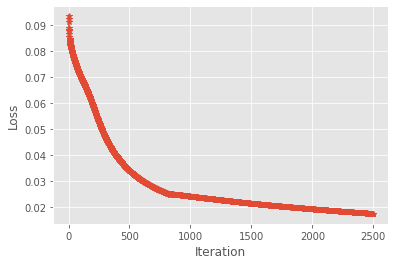

In [14]:
loss_history = train_setup(net_att, lr=0.001, n_batches=2500, batch_size = 256, display_freq=10, device = device_gpu)
torch.save(net_att.state_dict(), '/content/drive/My Drive/Colab Notebooks/CapstoneProject/seq2seq_attn.pth')

## Inference

In [ ]:
def test(net, word, device = 'cpu'):
    net = net.eval().to(device)
    outputs = infer(net, word, MAX_OUTPUT_CHARS, device)
    actual_output = ''
    for out in outputs:
        val, indices = out.topk(1)
        index = indices.tolist()[0][0]
        if index == 0:
            break
        actual_output_char = eng_alphabets[index+1]
        actual_output += actual_output_char
    print(word + ' - ' + actual_output)
    return actual_output

test(net_attn,test_data)

In [ ]:
def calc_accuracy(net, device = 'cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    correct = 0
    for i in range(len(test_data)):
        hindi, english = test_data[i]
        gt = eng_rep(english, eng_alpha2index, device)
        outputs = infer(net, hindi, gt.shape[0], device)

        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            eng_pos = indices.tolist()[0]
            if eng_pos[0] == gt[index][0]:
                correct += 1
        
        accuracy += correct/gt.shape[0]
    accuracy /= len(test_data)
    return accuracy

accuracy = calc_accuracy(net_att)
print('Acurracy', accuracy)

In [1]:
1/196

0.00510204081632653